In [1]:
#%matplotlib widget

In [2]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_simple
import ariel_gp
import ariel_load
import ariel_load_FGS
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import importlib
from tqdm import tqdm
kgs.debugging_mode = 1
kgs.profiling=False
kgs.n_workers = 6

local


In [3]:
train_data = kgs.load_all_train_data()
train_data = train_data

# train_data_multi = []
# train_data_single = []
# for d in train_data:
#     if len(d.transits)==1:
#         train_data_single.append(d)
#     else:
#         train_data_multi.append(d)
# len(train_data_multi), len(train_data_single)

# train_data = train_data_multi

In [4]:
# importlib.reload(kgs)
# for d in train_data:
#     d.spectrum_cov = np.ones((283,283))
# kgs.mats_to_data(train_data, train_data, kgs.data_to_mats(train_data,train_data))
# kgs.score_metric(train_data, train_data)

In [5]:
importlib.reload(ariel_model)
todo = dict()

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# todo['New transit prior, alpha=1.0, FGSs=0.0001'] = model

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# todo['New baseline fudger2 coupling'] = model

model = ariel_model.baseline_model()
model.model.run_in_parallel = True
todo['Baseline'] = model

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# model.model = ariel_model.MultiTransit(model=model.model)
# todo['Multi-transit'] = model

In [6]:

kgs.sanity_checks_active = True
def fname(k):
    return kgs.temp_dir + 'evaluate_model_'+k+'__'+str(len(train_data))+'.pickle'
for k,v in todo.items():
    if not os.path.isfile(fname(k)):
        print(k)
        model = copy.deepcopy(v)
        
#         print('!!! also loader')
#         if k=='Fudger3':
            
#             model_ref = kgs.dill_load(fname('Baseline'))[1]
#             model._cached_planet_id = model_ref._cached_planet_id
#             model._cached_result = model_ref._cached_result
#             # model.bias_a = model_ref.bias_a
#             # model.bias_b = model_ref.bias_b
#             # model.sigma_fudge_FGS = model_ref.sigma_fudge[0]
#             # model.sigma_fudge_AIRS_mean = model_ref.sigma_fudge[1]
#             # model.sigma_fudge_AIRS_var = model_ref.sigma_fudge[1]
        
        # Precache data
        print('precache off')
        #for d in tqdm(train_data):
        #    copy.deepcopy(d).load_to_step(5,model.model.starter_model.loaders)
        
        
        
        #model.state=1
        model.train(train_data)
        #kgs.list_attrs(model)
        inferred_data = model.infer(train_data)
        print(k)
        print(kgs.score_metric(inferred_data, train_data))
        #print('not saving')
        #kgs.list_attrs(model)
        #if k=='Baseline':
        kgs.dill_save(fname(k), (inferred_data,train_data,model,kgs.git_commit_id))
        #print(inferred_data[0].spectrum[0], inferred_data[0].spectrum_cov[0,0])
        #print(inferred_data[-1].spectrum[0], inferred_data[-1].spectrum_cov[0,0])
    else:
        print(k)
        (inferred_data,train_data_here,model,_) = kgs.dill_load(fname(k))
        #print(model.model.model_options.FGS_order)
        print(kgs.score_metric(inferred_data, train_data_here))

Baseline
precache off


Processing in parallel:   0%|                                                                  | 0/1099 [00:00<?, ?it/s]

local
local
SpawnPoolWorker-6 6
CUDA_VISIBLE_DEVICES= 0
SpawnPoolWorker-5 5
CUDA_VISIBLE_DEVICES= 0
local
local
local
SpawnPoolWorker-3 3
CUDA_VISIBLE_DEVICES= 0
local
SpawnPoolWorker-1 1
CUDA_VISIBLE_DEVICES= 0
SpawnPoolWorker-2 2
CUDA_VISIBLE_DEVICES= 0
SpawnPoolWorker-4 4
CUDA_VISIBLE_DEVICES= 0


Processing in parallel: 100%|███████████████████████████████████████████████████████| 1099/1099 [28:57<00:00,  1.58s/it]


Opt time 1762.2210068702698
Baseline
Score:           0.6058
RMS error FGS:   201.23197 ppm
mRMS error FGS:  56.71861 ppm
RMS error AIRS:  157.06401 ppm
mRMS error AIRS: 61.48104 ppm
RMS error AIRSv: 70.19402 ppm
mRMS error AIRSv:39.26299 ppm
(0.6058437719977078, 0.00020123197369274165, 0.0001570640121654932)


/mnt/d//ariel2/temp/evaluate_model_Baseline__1099.pickle
[0.9999910010259859, 0.9979475054369765]
[-7.4167322054109155e-06, 8.409302517562231e-06]
[-1.102304551152567e-06, 8.49708607848487e-06]
2.4519319490767026 2.1104210964171437 1.3661492432514684
Score:           0.6058
RMS error FGS:   201.23197 ppm
mRMS error FGS:  56.71861 ppm
RMS error AIRS:  157.06401 ppm
mRMS error AIRS: 61.48104 ppm
RMS error AIRSv: 70.19402 ppm
mRMS error AIRSv:39.26299 ppm
(0.6058437719977078, 0.00020123197369274165, 0.0001570640121654932)


No fudge
Score:           0.5191
RMS error FGS:   201.23197 ppm
mRMS error FGS:  56.71861 ppm
RMS error AIRS:  157.06401 ppm
mRMS error AIRS: 61.48104 ppm
RMS error AIRSv: 70.19402 ppm
mRMS error AIRSv:39.26299 ppm
FGS
1843015807, ratio:0.165, x:1.570e-02, y:2.596e-03, RMS:2.269e-03
576917580, ratio:0.101, x:1.946e-02, y:1.970e-03, RMS:1.523e-03
AIRS
1843015807, ratio:0.142, x:1.600e-02, y:2.266e-03, RMS:2.269e-03
2554492145, ratio:0.105, x:1.086e-02, y:1.143e-03, RMS:

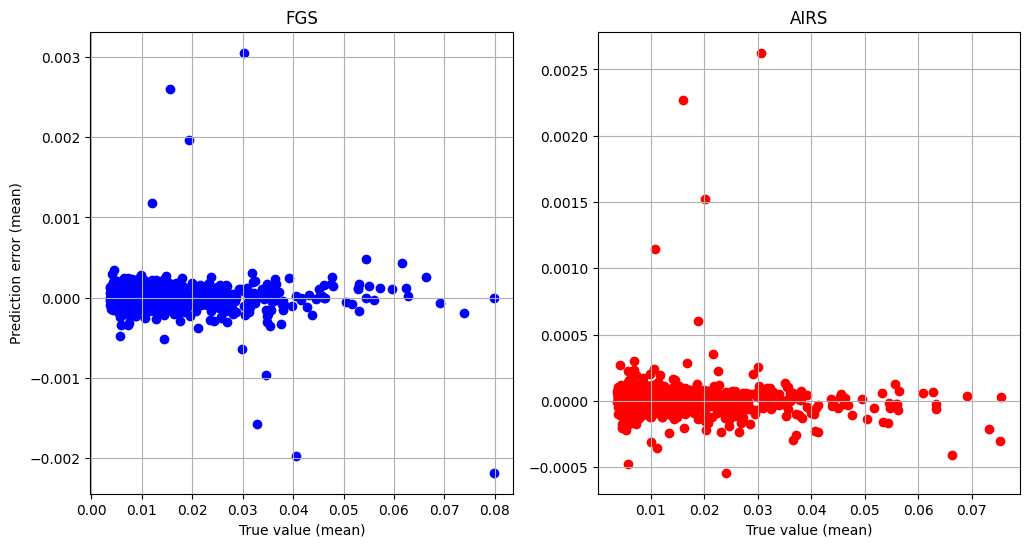

FGS
1349926825, ratio:26.676, x:8.178e-05, y:-2.181e-03, RMS:1.027e-03
3786449677, ratio:25.310, x:7.774e-05, y:-1.968e-03, RMS:4.956e-04
AIRS
94572221, ratio:24.369, x:1.940e-05, y:-4.728e-04, RMS:4.731e-04
2554492145, ratio:21.140, x:5.407e-05, y:1.143e-03, RMS:1.154e-03


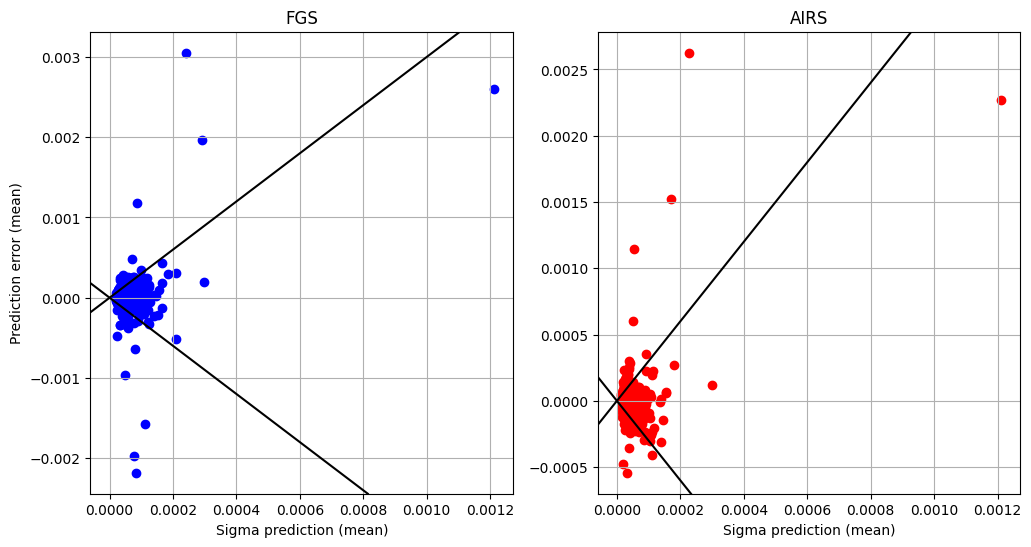

FGS
3669562759, ratio:24752255.520, x:4.804e-08, y:1.189e+00, RMS:2.369e-05
4084207590, ratio:21303597.292, x:2.447e-08, y:5.212e-01, RMS:2.114e-05
AIRS
4084207590, ratio:25551002.333, x:2.447e-08, y:6.252e-01, RMS:2.114e-05
3669562759, ratio:21194356.823, x:4.804e-08, y:1.018e+00, RMS:2.369e-05


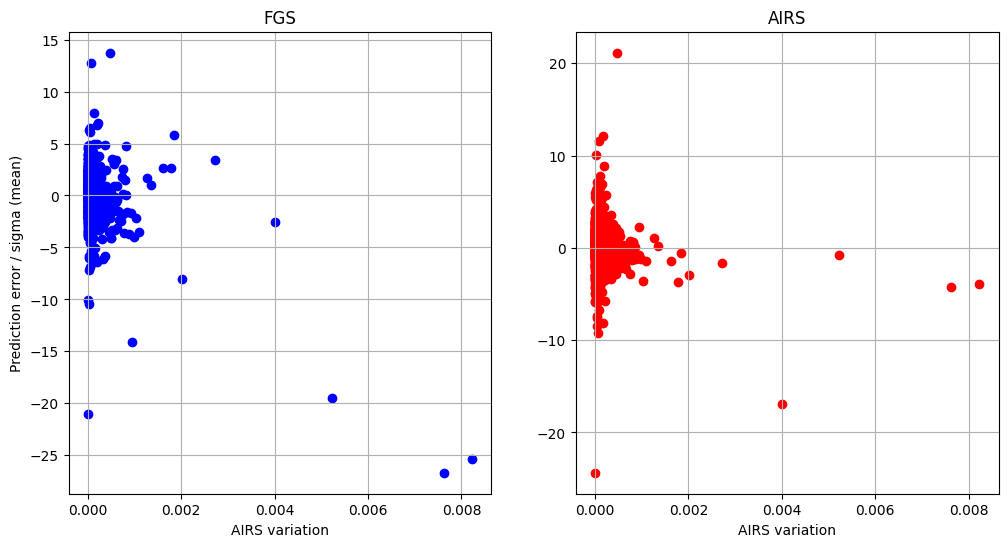

FGS
1349926825, ratio:24.408, x:1.093e+00, y:-2.668e+01, RMS:1.027e-03
3786449677, ratio:24.138, x:1.049e+00, y:-2.531e+01, RMS:4.956e-04
AIRS
2554492145, ratio:21.062, x:1.004e+00, y:2.114e+01, RMS:1.154e-03
94572221, ratio:20.581, x:1.184e+00, y:-2.437e+01, RMS:4.731e-04


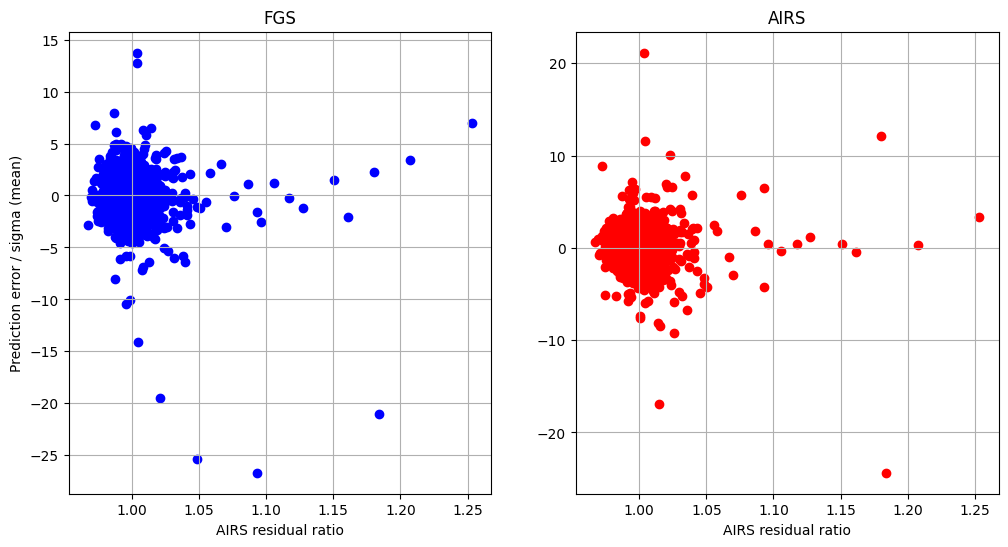

FGS
1349926825, ratio:26.951, x:9.898e-01, y:-2.668e+01, RMS:1.027e-03
3786449677, ratio:25.140, x:1.007e+00, y:-2.531e+01, RMS:4.956e-04
AIRS
94572221, ratio:23.602, x:1.032e+00, y:-2.437e+01, RMS:4.731e-04
2554492145, ratio:20.875, x:1.013e+00, y:2.114e+01, RMS:1.154e-03


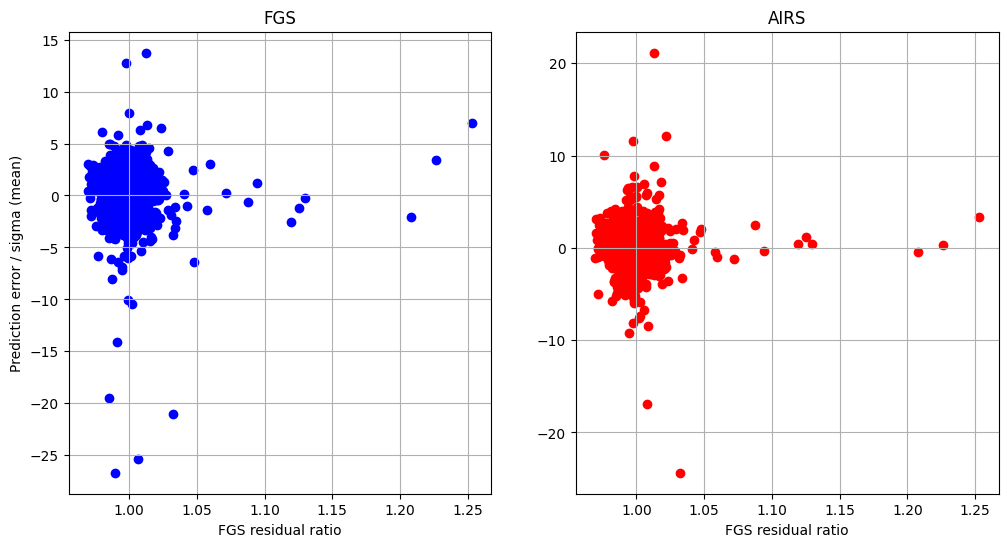

AIRS variation
1349926825, ratio:10.422, x:9.584e-05, y:9.989e-04, RMS:1.027e-03
2270815333, ratio:10.248, x:9.002e-05, y:9.225e-04, RMS:1.068e-03


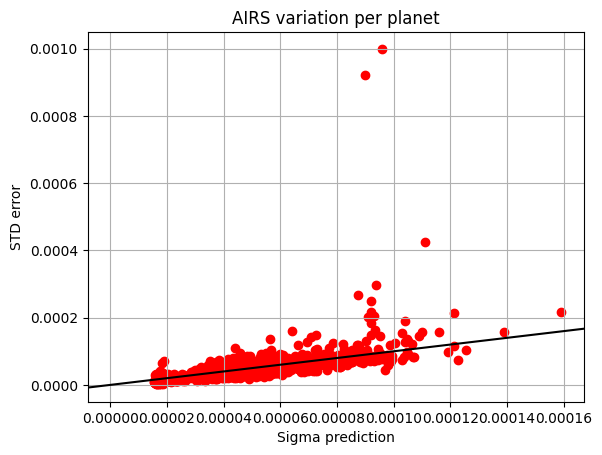

FGS
4084207590, ratio:20987022.996, x:2.447e-08, y:5.135e-01, RMS:2.114e-05
3669562759, ratio:9321508.732, x:4.804e-08, y:4.478e-01, RMS:2.369e-05
AIRS
4084207590, ratio:20987022.996, x:2.447e-08, y:5.135e-01, RMS:2.114e-05
3669562759, ratio:9321508.732, x:4.804e-08, y:4.478e-01, RMS:2.369e-05


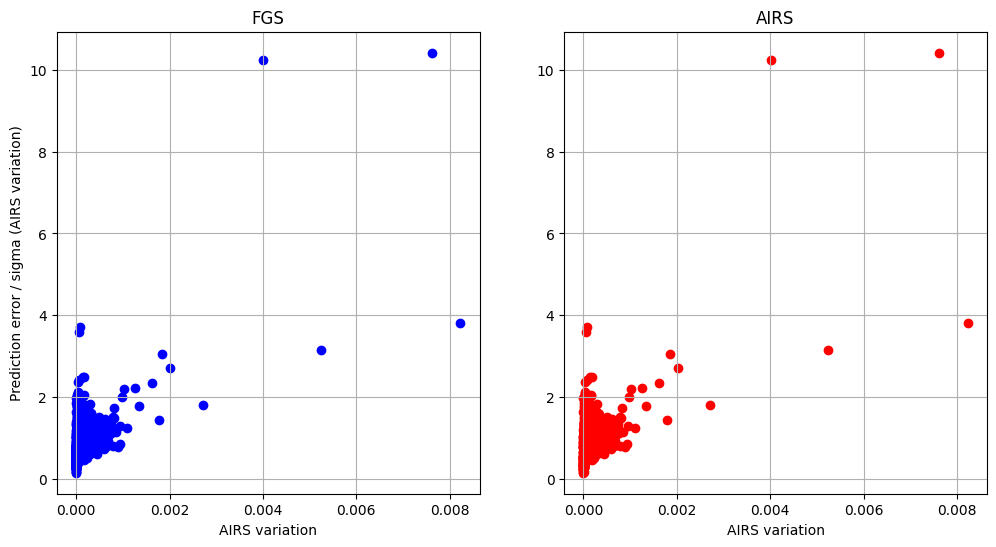

In [11]:
ignore_bad_planets = False
def filter_bad_data(data):
    data_out = []
    for d in data:
        if not d.planet_id in [1349926825, 3786449677, 2554492145, 1267010874, 94572221, 2270815333, 3649218579, 576917580, 2154305089, 2207815333, 2740910036]:
            data_out.append(d)
    return data_out
        
def basics():
    plt.grid(True)
    plt.box(True)
def plot_two_sensors(func, xl, yl, mod):
    _,ax = plt.subplots(1,2,figsize=(12,6))
    plt.sca(ax[0]);basics()
    plt.title('FGS')
    plt.xlabel(xl)
    plt.ylabel(yl)
    func(slice(0,1), 'blue', 'FGS')
    mod()
    
    plt.sca(ax[1]);basics()
    plt.title('AIRS')
    plt.xlabel(xl)
    func(slice(1,283), 'red', 'AIRS')
    mod()
    
    plt.pause(0.001)

def report_extreme_ratios(x,y,name):
    
    print(name)
    inds = np.argsort(np.abs(y/x))[::-1]
    for ii in inds[:2]:
        print(f'{inferred_data[ii].planet_id}, ratio:{np.abs(y[ii]/x[ii]):.3f}, x:{x[ii]:.3e}, y:{y[ii]:.3e}, RMS:{kgs.rms(error_matrix[ii,:]):.3e}')
    
    
fname_list = [fname(k) for k in todo.keys()]
#fname_list = ['evaluate_model_Baseline__989.pickle', 'evaluate_model_Baseline__110.pickle', 'evaluate_model_Multi-transit__110.pickle']
for f in fname_list:
    (inferred_data,train_data_here,model,_) = kgs.dill_load(f)
    if ignore_bad_planets:
        inferred_data = filter_bad_data(inferred_data)
        train_data_here = filter_bad_data(train_data_here)
    else:
        train_data_here = train_data_here
    #model.bias_a[0]+=0.006
    #model.bias_a[1]-=0.0002
    #inferred_data = model.infer(train_data)
    
    
    print(f)
    print(model.bias_a)
    print(model.bias_b)
    print(model.sigma_offset)
    print(model.sigma_fudge_FGS, model.sigma_fudge_AIRS_mean, model.sigma_fudge_AIRS_var)
    
    print(kgs.score_metric(inferred_data, train_data_here,print_results=True))
    print('')
    
    
    
    
    #try:
    #    print(model.sigma_offset)
    #except: pass
    #print(model.sigma_fudge)    
    #kgs.list_attrs(model)
    #kgs.score_metric(inferred_data, train_data_here)
    print('')
    #print('3')
    #kgs.score_metric(inferred_data[:3], train_data_here[:3]) 
    #print('')
    print('No fudge')
    #model.sigma_fudge = [1,1]
    #try: model.sigma_offset = [0,0]
    #except: pass
    #model.bias_a = [1,1]
    #model.bias_b = [0,0]
    # print('!!!')
    model.sigma_offset = [0,0]
    model.sigma_fudge_FGS = 1.
    model.sigma_fudge_AIRS_mean = 1.
    model.sigma_fudge_AIRS_var = 1.
    inferred_data = model.infer(train_data_here)
    if ignore_bad_planets:
        inferred_data = filter_bad_data(inferred_data)
    kgs.score_metric(inferred_data, train_data_here)     
    error_matrix = np.array([d.spectrum - t.spectrum for d,t in zip(inferred_data,train_data_here)])
    true_matrix = np.array([t.spectrum for d,t in zip(inferred_data,train_data_here)])
    
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(true_matrix[:,slic],1)
        y = np.mean(error_matrix[:,slic],1)
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)
        
    plot_two_sensors(plot_prediction_vs_true, 'True value (mean)', 'Prediction error (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data]
        y = np.mean(error_matrix[:,slic],1)
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)
    def mod():
        plt.axline((0,0), slope=3, color='black')
        plt.axline((0,0), slope=-3, color = 'black')        
    plot_two_sensors(plot_mean_error_vs_sigma, 'Sigma prediction (mean)', 'Prediction error (mean)', mod)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = np.mean(true_matrix[:,slic],1)
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#     plot_two_sensors(plot_mean_error_vs_sigma, 'True value (mean)', 'Prediction error / sigma (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = np.std(true_matrix[:,1:],1)
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
    plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS variation', 'Prediction error / sigma (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [d.diagnostics['simple_residual_diff_AIRS'] for d in inferred_data]
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
    plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS residual ratio', 'Prediction error / sigma (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [d.diagnostics['simple_residual_diff_FGS'] for d in inferred_data]
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
    plot_two_sensors(plot_mean_error_vs_sigma, 'FGS residual ratio', 'Prediction error / sigma (mean)', lambda:0)
    
    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel('Sigma prediction')
    plt.ylabel('STD error')
    n=282
    x=np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
    y=np.sqrt(np.var(error_matrix[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    report_extreme_ratios(x,y,'AIRS variation')    
    plt.pause(0.001)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = np.mean(true_matrix[:,slic],1)
#         y = np.sqrt(np.var(error_matrix[:,1:],1)) / np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
#         plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#     plot_two_sensors(plot_mean_error_vs_sigma, 'True value (mean)', 'Prediction error / sigma (AIRS variation)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = np.std(true_matrix[:,1:],1)
        y = np.sqrt(np.var(error_matrix[:,1:],1)) / np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
    plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS variation', 'Prediction error / sigma (AIRS variation)', lambda:0)
    
    
    

In [8]:
compare1= list(todo.keys())[0]
data1 = kgs.dill_load(fname(compare1))[0]
if ignore_bad_planets:
    data1 = filter_bad_data(data1)
for k,v in todo.items():    
    compare2= k
    if compare2==compare1:
        continue    
    data2 = kgs.dill_load(fname(compare2))[0]
    if ignore_bad_planets:
        data2 = filter_bad_data(data2)
        train_data_here = filter_bad_data(train_data)
    else:
        train_data_here = train_data           
    error1 = np.array([d.spectrum - t.spectrum for d,t in zip(data1,train_data_here)])
    error2 = np.array([d.spectrum - t.spectrum for d,t in zip(data2,train_data_here)])
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(error1[:,slic],1)
        y = np.mean(error2[:,slic],1)
        plt.scatter(x,y,color = col)

    plot_two_sensors(plot_prediction_vs_true, compare1+' (mean)', compare2+' (mean)', lambda:plt.axline((0,0),slope=1,color='black'))

    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel(compare1)
    plt.ylabel(compare2)
    x=np.sqrt(np.var(error1[:,1:],1))
    y=np.sqrt(np.var(error2[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    plt.pause(0.001)

In [9]:
# import subprocess

# # Hibernate Windows
# subprocess.run(
#     ["/mnt/c/Windows/System32/shutdown.exe", "/h"],  # add "/f" to force-close apps
#     check=True
# )